In [621]:
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom, center_of_mass, shift
import cv2

import ipywidgets
from pathlib import Path
from tqdm import tqdm
from collections import Counter


In [2]:
%load_ext autoreload
%autoreload 2

In [118]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume

/home/eddyod/programming/pipeline/src


In [728]:
def filter_top_n_values(volume: np.ndarray, n: int, set_value: int = 1) -> np.ndarray:
    """
    Get the `n` most common unique values from a numpy volume.
    Sets those values to `set_value` and the rest to 0.

    Parameters:
        volume (np.ndarray): Input 3D volume.
        n (int): Number of most common unique values to retain.
        set_value (int, optional): The value to assign to the most common values. Defaults to 1.

    Returns:
        np.ndarray: Transformed volume.
    """
    
    # Flatten the volume and count occurrences of unique values
    values, counts = np.unique(volume[volume != 0], return_counts=True)
    
    # Get the top `n` most common values
    top_n_values = [val for val, _ in Counter(dict(zip(values, counts))).most_common(n)]
    print(f'top {n} {top_n_values=}')
    
    # Create a mask where only top N values are retained
    mask = np.isin(volume, top_n_values)
    
    # Set the selected values to `set_value` and the rest to 0
    result = np.where(mask, set_value, 0)
    
    return result


def center_3d_volume(volume: np.ndarray) -> np.ndarray:
    """
    Centers a 3D volume by shifting its center of mass to the geometric center.

    Parameters:
    volume (np.ndarray): A 3D numpy array representing the volume.

    Returns:
    np.ndarray: The centered 3D volume.
    """
    if volume.ndim != 3:
        raise ValueError("Input volume must be a 3D numpy array")
    
    # Compute the center of mass
    com = np.array(center_of_mass(volume))
    
    # Compute the geometric center
    shape = np.array(volume.shape)
    geometric_center = (shape - 1) / 2
    
    # Compute the shift required
    shift_values = geometric_center - com
    
    # Apply shift
    centered_volume = shift(volume, shift_values, mode='constant', cval=0)
    
    return centered_volume

def crop_nonzero_3d(volume):
    """
    Crops a 3D volume to remove all-zero regions.
    
    Parameters:
        volume (numpy.ndarray): A 3D NumPy array.
        
    Returns:
        numpy.ndarray: The cropped 3D volume.
    """
    if volume.ndim != 3:
        raise ValueError("Input volume must be a 3D NumPy array")
    
    # Find nonzero elements
    nonzero_coords = np.argwhere(volume)
    
    # Get bounding box of nonzero elements
    min_coords = nonzero_coords.min(axis=0)
    max_coords = nonzero_coords.max(axis=0) + 1  # Add 1 to include the max index
    
    # Crop the volume
    cropped_volume = volume[min_coords[0]:max_coords[0],
                            min_coords[1]:max_coords[1],
                            min_coords[2]:max_coords[2]]
    
    return cropped_volume

def normalize16(img):
    if img.dtype == np.uint32:
        print('image dtype is 32bit')
        return img.astype(np.uint16)
    else:
        mn = img.min()
        mx = img.max()
        mx -= mn
        img = ((img - mn)/mx) * 2**16 - 1
        return np.round(img).astype(np.uint16) 


In [5]:
arrpath = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{atlas}/structure/{structure}.npy'
arr7 = np.load(arrpath)
arr7 = np.rot90(arr7, axes=(0, 1)) 
arr7 = np.flip(arr7, axis=0)
arr7[arr7 > threshold] = allen_color
arr7[arr7 != allen_color] = 0
print(arr7.shape, arr7.dtype)

(116, 123, 62) float64


In [388]:
animal = 'MD594'
path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}/structure/{structure}.npy'
arr = np.load(path)
#animal_volume[animal_volume > threshold] = allen_color
#animal_volume[animal_volume != allen_color] = 0
print(arr.shape, arr.dtype)

[  0 100]
[9204440 4046512]
(198, 198, 338) int64


In [753]:
structure = 'VCA_L'
structure = 'SC'
structure = '3N_R'
allen_color = 851
threshold = 0.50
atlas = 'AtlasV8'

[-17. -15. -15. ... 273. 274. 274.]
[1 1 1 ... 1 1 1]
float32 (57, 42, 24)


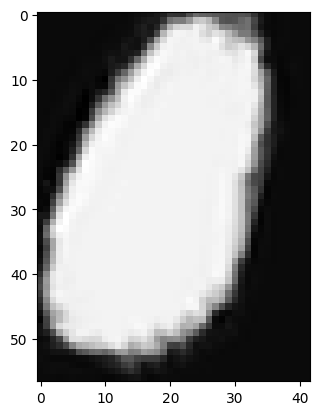

In [754]:
arrpath = os.path.join(data_path, f'{atlas}/structure/{structure}.npy')
arr = np.load(arrpath)
ids, counts = np.unique(arr, return_counts=True)
print(np.round(ids))
print(counts)
print(arr.dtype, arr.shape)
z = arr.shape[2] // 2
plt.imshow(arr[:, :, z], cmap="gray")

[  0 851]
[33759 23697]
uint32


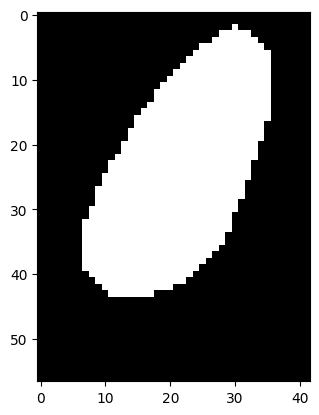

In [755]:
volume = arr.copy()
lower = 60
upper = 150
#volume = gaussian(volume, 1.0)
#volume[(volume > 0) & (volume < upper)] = allen_color
volume = gaussian(volume, 4.0)
volume[(volume > upper) ] = allen_color
volume[(volume < upper)] = 0
#volume[volume > 0] = allen_color
#volume[(volume < upper)] = allen_color
#volume[volume != allen_color] = 0
fake_number = 666
#volume[volume == allen_color] = fake_number
#volume[volume == 0] = 10
#volume[volume == fake_number] = 0
#volume[volume == 10] = allen_color
volume = volume.astype(np.uint32)
#volume[(volume > upper) ] = allen_color
#volume[(volume < upper)] = 0
ids, counts = np.unique(volume, return_counts=True)
print(ids)
print(counts)
print(volume.dtype)

z = volume.shape[2] // 20
plt.imshow(volume[:, :, z], cmap="gray")

/usr/local/share/pipeline/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


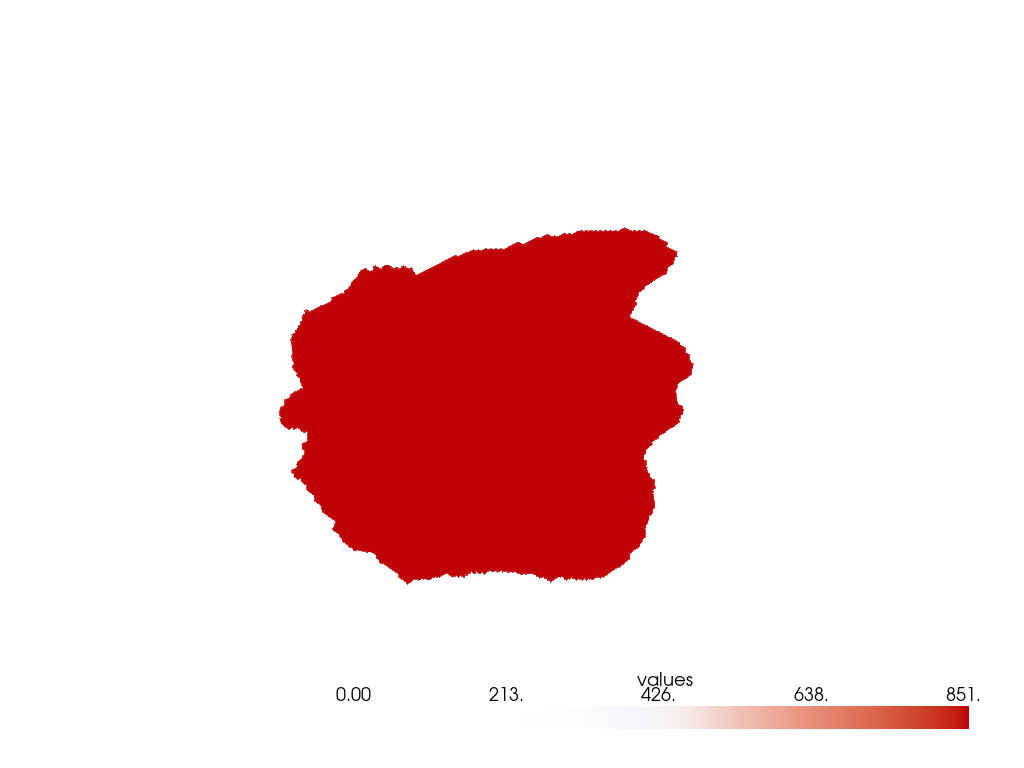

In [465]:
#pv.set_jupyter_backend("trame")
#data = pv.wrap(volume)
#data.plot(volume=True) # Volume render
# Plot the volume with a transfer function
plotter = pv.Plotter()
plotter.add_volume(volume, cmap="coolwarm", opacity="sigmoid", show_scalar_bar=True)
plotter.show()

In [440]:
images = [-14, 7, -9, 2]
max_index, max_value = max(enumerate(images), key=lambda x: x[1])

In [674]:
a = np.array([1,2,3], dtype=np.float32)
print(a)

[1. 2. 3.]


In [438]:
max_val = max(images)
idx_max = images.index(max_val)
print(max_val, idx_max)
print(images)
del images[idx_max]
print(images)

7 1
[-14, 7, -9, 2]
[-14, -9, 2]
